# TP : RN-AlgoGN

**Exercice 1** :  
On se donne l’image Fry.bmp.  
On souhaite faire un réseau de neurones qui agissent
sur les neurones d’entrées associés à l’image Fry.bmp.  
Un neurone est un pixel de l’image qui est
à 0 ou à 1.

Pour chaque pixel i, on renvoie $e_i = 1 $ si $\sum_{j~voisin~du~pixel} a_{ji } * e_{j}$ > seuil, 0 sinon.
1) Cas 1 : les $a_{voisin} = 1$ faire varier le seuil, observer le résultat et expliquer le.
2) Cas 2 : les $a_{ji,voisin~j\ne i} = −1$, aii = α, faire varier α et la valeur du seuil, observer le résultat et expliquer le.

## Import

In [1]:
from skimage import io
import matplotlib.pyplot as plt
import numpy as np

In [2]:
image = io.imread('Fry/Fry.bmp')

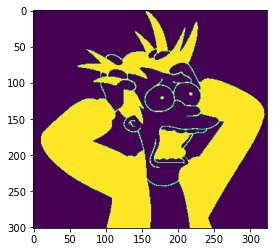

In [3]:
plt.imshow(image)

## Premier cas : $a_{voisin} = 1$

In [4]:
def cas1(image,seuil):
    
    # on récupère les dimensions
    n,m = image.shape
    
    # les resultats sont stockés sur une nouvelles image
    results = np.zeros((n,m))
    
    #condition du cas 1
    a_voisin = 1
    
    # on parcours l'image
    for i in range(n):
        for j in range(m):
            
            calcul = 0
            
            # parcourir les voisins
            for di in [-1, 0, 1]:
                for dj in [-1, 0, 1]:
                    
                    # calculer les indices des voisins
                    i2, j2 = i + di, j + dj
                    # vérifier si les indices sont dans les limites de la matrice
                    if i2 >= 0 and i2 < n and j2 >= 0 and j2 < m :
                        calcul += a_voisin * image[i2,j2]/255 #on normalise
                        
            # application de la condition
            if calcul > seuil :
                results[i,j] = 1
            else : 
                results[i,j] = 0
                
    return results

In [5]:
image2 = cas1(image,7)

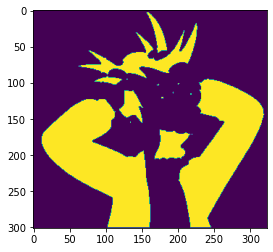

In [6]:
plt.imshow(image2)

In [7]:
def cas2(image,seuil=0.1,alpha=0.1):
    
     # on récupère les dimensions
    n,m = image.shape
    
    # les resultats sont stockés sur une nouvelles image
    results = np.zeros((n,m))
    
    #condition du cas 2
    a_voisin = -1
    
    # on parcours l'image
    for i in range(n):
        for j in range(m):
            
            calcul = 0
            
            # parcourir les voisins
            for di in [-1, 0, 1]:
                for dj in [-1, 0, 1]:
                    
                    # calculer les indices des voisins
                    i2, j2 = i + di, j + dj
                    # vérifier si les indices sont dans les limites de la matrice
                    if i2 >= 0 and i2 < n and j2 >= 0 and j2 < m :
                        if i2 != i and j2 != j :
                            calcul += a_voisin * image[i2,j2]/255
                        else : 
                            calcul += alpha * image[i2,j2]/255
                        
            # application de la condition
            if calcul > seuil :
                results[i,j] = 1
            else : 
                results[i,j] = 0
                
    return results

In [8]:
image3 = cas2(image,1,1)

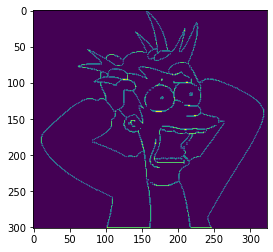

In [9]:
plt.imshow(image3)

## Problème 2 :

### Question 1 : Création des fonction de base du problème et du modèle

On remarque qu'une solution est [1,0,0] .
Ainsi, notre code devrais converger vers au moins une solution si il est bien fait ! 

In [10]:
def norm2(X):
    calcul = 0
    for i in X:
        calcul += i*i
    return np.sqrt(calcul)

In [11]:
def heaviside(x):
    if x < 0:
        return 0
    else:
        return 1

In [12]:
def linear(x,T=1):
    return min(1,max(0,T*x))

In [13]:
def sigmoid(x,T=1):
    return 1/(1+np.exp(-T*x))

In [14]:
# E est le vecteur d'entree
# P est le vecteur de Poids
# h est la fonction d'activation

def architecture0(E,P,h):
    return h(np.dot(E,P))

In [15]:
E_th1 = np.array([[0,0,1],
        [1,1,1],
        [1,0,1],
        [0,1,1]])
S_th1 = np.array([0,1,1,0])

In [16]:
# la norme 2 correspond à la racine de la somme des carrés des composantes
def err(Q,h,E_th,S_th):
    R = np.zeros(len(E_th))
    for i in range(len(E_th)):
        R[i] = architecture0(E_th[i],Q,h)
    return norm2(R-S_th)

In [17]:
# calcul de err pour un vecteur de poids Q et une fonction d'activation h et S
def err_vecteur(P,h,E_th,S_th):
    err_l = np.zeros(len(P))
    for i in range(len(P)):
        err_l[i]=err(P[i],h,E_th,S_th)
    return err_l

### Question 2 : initialisation d'une population et affichage des erreurs

In [18]:
def generation_P(taille_pop):
    return np.random.uniform(-20,20,(taille_pop,3))

In [19]:
err_vecteur(generation_P(20),heaviside,E_th1,S_th1)

array([1.        , 1.        , 1.41421356, 1.41421356, 1.41421356,
       1.41421356, 1.41421356, 1.41421356, 1.41421356, 1.41421356,
       1.41421356, 1.73205081, 1.73205081, 1.41421356, 1.41421356,
       1.41421356, 1.        , 1.41421356, 2.        , 1.73205081])

### Question 3 : création d'un algo génétique d'amélioration de poids

Ici, on va suivre 3 étapes pour réaliser l'aglo génétique :
- sélection des meilleurs fourmis
- Croisement 
- mutation 

In [20]:
# crée une fonction trie le vecteur Poids selon la fonction d'erreur err
def trier(P,h,E_th,S_th):
    return P[np.argsort(err_vecteur(P,h,E_th,S_th))]

In [21]:
# comme P est trié, on sait que le meilleur indice est 0 (on cherche à minimiser l'erreur)
def croisement(P,n_croisement):
    n = len(P)
    for i in range(n_croisement):
        P[n-1-i] = (P[0]+P[n-1-i])/2
    return P

In [22]:
def mutation(P,n_mutation,n_croisement,alpha):
    n = len(P)
    for i in range(n_mutation):
        P[n-1-i-n_croisement] = P[0]+np.random.rand(3)*alpha
    return P

In [23]:
# P est la population de poids
# h est la fonction d'activation
# n_croisement est le nombre de croisement à effectuer
# n_mutation est le nombre de mutation à effectuer
# alpha est le facteur de mutation
# n_gen est le nombre de génération à effectuer

def algo_genetique(P,h,n_croisement,n_mutation,alpha,n_gen,E_th,S_th):
    for i in range(n_gen):
        P = trier(P,h,E_th,S_th)
        P = croisement(P,n_croisement)
        P = mutation(P,n_mutation,n_croisement,alpha)
    return P

In [24]:
test = generation_P(20)

In [25]:
print(test)

[[ -2.06346226   2.83010826  -8.44479285]
 [ 14.07040468  -6.58906833  13.56746215]
 [ 16.52378431 -10.15669721  -5.40669255]
 [-13.10082299  10.73575529 -19.8471572 ]
 [ -2.71478902  18.784584    15.44864328]
 [  5.79134258  15.4153606  -13.10743975]
 [ -1.52327583   2.00552942   5.82258331]
 [ 17.68214621 -13.2261928    3.82186153]
 [  7.73363088  19.82614596  19.33430565]
 [-19.22163365   9.2381902  -18.3435737 ]
 [-19.35471547  15.05567365   7.94940925]
 [-12.16697437  15.16220813  18.65109165]
 [  8.19322316 -11.64501497  17.61322996]
 [ -0.41081357  -1.83908636  17.7377741 ]
 [-10.6404953  -11.50736609  -4.92558238]
 [  2.21107286 -13.99177567 -11.42401543]
 [ 14.97393385  10.96866741  -8.61744921]
 [ -1.31561875  19.09797075  -0.62052565]
 [  5.56030634   7.24323312 -12.26133782]
 [ -9.9838548    2.21180828 -15.67060331]]


In [26]:
# avec heaviside
P1 = algo_genetique(test,heaviside,5,5,0.1,100,E_th1,S_th1)
print(P1)
print(err_vecteur(P1,heaviside,E_th1,S_th1))

[[ 16.52378431 -10.15669721  -5.40669255]
 [ 16.52378431 -10.15669721  -5.40669255]
 [ 16.52378431 -10.15669721  -5.40669255]
 [ 16.52378431 -10.15669721  -5.40669255]
 [ 16.62171846 -10.14146397  -5.31144112]
 [ 16.56734146 -10.12221311  -5.31046008]
 [ 16.60776734 -10.12723089  -5.3099024 ]
 [ 16.58115032 -10.14607586  -5.32130274]
 [ 16.62135879 -10.11954104  -5.32188435]
 [ 16.57710053 -10.09369372  -5.40487926]
 [ 16.58180268 -10.14055916  -5.36175704]
 [ 16.61368    -10.07073268  -5.39034477]
 [ 16.62161469 -10.12526389  -5.31778464]
 [ 16.57620648 -10.08447562  -5.35929708]
 [ 16.57732629 -10.14395199  -5.37480219]
 [ 16.52378431 -10.15669721  -5.40669255]
 [ 16.52378431 -10.15669721  -5.40669255]
 [ 16.52378431 -10.15669721  -5.40669255]
 [ 16.52378431 -10.15669721  -5.40669255]
 [ 16.52378431 -10.15669721  -5.40669255]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [27]:
# avec linear
P2 = algo_genetique(test,linear,5,5,0.1,100,E_th1,S_th1)
print(P2)
print(err_vecteur(P2,linear,E_th1,S_th1))

[[ 16.6083721  -10.12934333  -5.3519436 ]
 [ 16.6083721  -10.12934333  -5.3519436 ]
 [ 16.6083721  -10.12934333  -5.3519436 ]
 [ 16.6083721  -10.12934333  -5.3519436 ]
 [ 16.61711186 -10.12264645  -5.28748658]
 [ 16.6428217  -10.09780242  -5.31825138]
 [ 16.69677207 -10.04627319  -5.26283341]
 [ 16.67063518 -10.07252011  -5.34636523]
 [ 16.6173311  -10.10590261  -5.32243668]
 [ 16.70733088 -10.05432743  -5.27162897]
 [ 16.70354029 -10.11903978  -5.26103798]
 [ 16.69434178 -10.12391387  -5.28060304]
 [ 16.62507618 -10.07074296  -5.30990401]
 [ 16.65989699 -10.04171256  -5.34058677]
 [ 16.67890119 -10.04464807  -5.29287467]
 [ 16.6083721  -10.12934333  -5.3519436 ]
 [ 16.6083721  -10.12934333  -5.3519436 ]
 [ 16.6083721  -10.12934333  -5.3519436 ]
 [ 16.6083721  -10.12934333  -5.3519436 ]
 [ 16.6083721  -10.12934333  -5.3519436 ]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [28]:
# avec sigmoid
P3 = algo_genetique(test,sigmoid,5,5,0.1,100,E_th1,S_th1)
print(P3)
print(err_vecteur(P3,sigmoid,E_th1,S_th1))

[[18.68629856 -7.97209659 -4.09498615]
 [18.70547208 -7.89760559 -4.09394251]
 [18.60467489 -8.06591498 -4.09554418]
 [18.56217149 -8.15065023 -4.09654444]
 [18.54359417 -8.17665477 -4.09696241]
 [18.61485286 -8.11227976 -4.09509337]
 [18.70168062 -8.03786735 -4.09325286]
 [18.493652   -8.24851935 -4.09809161]
 [18.55323049 -8.22040963 -4.09637946]
 [18.62407268 -8.14106723 -4.0940031 ]
 [18.78262767 -7.91787115 -4.06693166]
 [18.7273152  -7.96752785 -4.09000247]
 [18.69000793 -7.88212645 -4.00271495]
 [18.77144871 -7.9164216  -4.06982584]
 [18.73254726 -7.88469892 -4.01207142]
 [18.72361393 -7.93165831 -4.07276575]
 [18.70339175 -7.96304692 -4.07183006]
 [18.69140909 -7.96800438 -4.06818049]
 [18.71235522 -7.96182554 -4.06148841]
 [18.72260872 -7.95084396 -4.04824053]]
[0.01643722 0.01644468 0.01645101 0.01645737 0.01646    0.01646391
 0.01647058 0.01647211 0.01647682 0.01648449 0.01687825 0.01651229
 0.01797243 0.01683144 0.01780662 0.01678843 0.01680841 0.01686977
 0.0169773  0.0171

### Exercice 2bis : Même chose que l'exercice 2 mais avec une tableau théorique différente

In [29]:
E_th2 = np.array([
        [0,0,1],
        [1,1,1],
        [1,0,1],
        [0,1,1]])
S_th2 = np.array([0,0,1,1])

In [30]:
test2 = generation_P(20)
print(test2)

[[-11.59956693   8.66499328   1.38282315]
 [  3.3454058   11.10185157  -9.34559634]
 [-19.63926543   6.63884669  13.59036118]
 [ 17.45362377 -17.04522087 -19.46636076]
 [ 19.39981168   7.34281365  10.66728638]
 [-10.36690777  -1.18716432 -19.26477028]
 [  4.891459     4.06171722  -2.64649049]
 [ 11.29018919  19.9547996  -18.77193043]
 [ 13.54460362  -8.36265563  -7.46379418]
 [-14.05241588 -13.17172451   3.76764799]
 [ 13.42286301  16.52970847  -8.21739311]
 [-15.54757644  17.95687707  11.61582354]
 [ 10.33828389  18.43421749   8.52463843]
 [  4.72835782   4.98478404   3.0471842 ]
 [ 11.63978731   3.69553937  -7.88006373]
 [  6.98756149  -7.28102044 -17.3832854 ]
 [-12.09703413  -2.44952598  -5.48903828]
 [-13.49271798  -8.54392636  -7.95111189]
 [ -2.42445592 -17.1399757   -1.50922654]
 [ 19.83365028   8.19248507  -3.64647159]]


In [31]:
# avec heaviside
P12 = algo_genetique(test2,heaviside,5,5,0.1,100,E_th2,S_th2)
print(P12)
print(err_vecteur(P12,heaviside,E_th2,S_th2))

[[19.83365028  8.19248507 -3.64647159]
 [19.83365028  8.19248507 -3.64647159]
 [19.83365028  8.19248507 -3.64647159]
 [19.83365028  8.19248507 -3.64647159]
 [19.84589237  8.2249939  -3.60810483]
 [19.8484868   8.19694666 -3.59057624]
 [19.86576269  8.21475429 -3.62119659]
 [19.84076496  8.2760399  -3.56437522]
 [19.90982667  8.26617223 -3.63413385]
 [19.89042022  8.21108196 -3.58316996]
 [19.86294267  8.21534937 -3.6395141 ]
 [19.87061851  8.28511797 -3.61535358]
 [19.93050928  8.28263378 -3.62474203]
 [19.8728218   8.19777363 -3.61568419]
 [19.83459039  8.23187317 -3.6369585 ]
 [19.83365028  8.19248507 -3.64647159]
 [19.83365028  8.19248507 -3.64647159]
 [19.83365028  8.19248507 -3.64647159]
 [19.83365028  8.19248507 -3.64647159]
 [19.83365028  8.19248507 -3.64647159]]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [32]:
# avec linear
P22 = algo_genetique(test2,linear,5,5,0.1,100,E_th2,S_th2)
print(P22)
print(err_vecteur(P22,linear,E_th2,S_th2))

[[19.83365028  8.19248507 -3.64647159]
 [19.83365028  8.19248507 -3.64647159]
 [19.83365028  8.19248507 -3.64647159]
 [19.83365028  8.19248507 -3.64647159]
 [19.89558125  8.22327359 -3.57419118]
 [19.87369482  8.25761926 -3.58530189]
 [19.92299364  8.21773738 -3.5767467 ]
 [19.83519909  8.21420528 -3.64313293]
 [19.92501173  8.20382743 -3.63581581]
 [19.86854443  8.24887461 -3.61488843]
 [19.88810676  8.26162465 -3.58333808]
 [19.89965525  8.21608042 -3.55527433]
 [19.87442499  8.21606764 -3.57266484]
 [19.8418128   8.26195692 -3.55126866]
 [19.84446039  8.28293827 -3.548965  ]
 [19.83365028  8.19248507 -3.64647159]
 [19.83365028  8.19248507 -3.64647159]
 [19.83365028  8.19248507 -3.64647159]
 [19.83365028  8.19248507 -3.64647159]
 [19.83365028  8.19248507 -3.64647159]]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [33]:
# avec sigmoid
P32 = algo_genetique(test2,sigmoid,5,5,0.1,100,E_th2,S_th2)
print(P32)
print(err_vecteur(P32,sigmoid,E_th2,S_th2))

[[15.86500625 18.22520903 -7.07242585]
 [15.7734849  18.17878623 -7.07524216]
 [15.89455028 18.25895672 -7.07080922]
 [15.69140119 18.17674069 -7.07859768]
 [15.81746242 18.24861332 -7.07257061]
 [15.92390657 18.25387087 -7.06817392]
 [15.76598632 18.21625016 -7.07280367]
 [15.59793503 18.08868406 -7.07963007]
 [15.75588046 18.22814843 -7.07035395]
 [15.50659537 17.99316398 -7.08220573]
 [15.91312492 18.24680938 -7.03830057]
 [15.95706551 18.24902165 -6.99235689]
 [15.94336134 18.30475382 -6.99777078]
 [15.93904754 18.22917663 -7.02539856]
 [15.92080587 18.32187792 -7.00031695]
 [15.88766914 18.23092254 -7.05246465]
 [15.90385051 18.2690644  -7.04356453]
 [15.88128063 18.26481105 -7.03006528]
 [15.90765345 18.23476932 -7.02565103]
 [15.90156582 18.26185607 -7.02382106]]
[1.00000037 1.00000037 1.00000037 1.00000037 1.00000037 1.00000037
 1.00000037 1.00000037 1.00000037 1.00000038 1.00000039 1.00000043
 1.00000043 1.0000004  1.00000042 1.00000038 1.00000039 1.0000004
 1.0000004  1.00000

On observe que nous ne convergeons pas vers une solution, je suppose quec c'est un problème non linéaire qui va demander l'utilisation de couches supplémentaires.

## Réseau de Neurones Multi-Couches

Ajout d'une couche intermédiaire de 4 neurones  
On transforme P en liste de listes de poids (chaque liste correspond à une couche)



In [34]:
# Nouvelle initialisation :
def generation_P_multicouche(taille_pop,taille_entree,liste_nb_neurones_par_couche):
    P = []
    for i in range(taille_pop):
        P.append([])
        for j in range(len(liste_nb_neurones_par_couche)) :
            if j == 0 :
                P[i].append(np.random.uniform(-20,20,(liste_nb_neurones_par_couche[j],taille_entree)))
            else :
                P[i].append(np.random.uniform(-20,20,(liste_nb_neurones_par_couche[j],liste_nb_neurones_par_couche[j-1])))
    return P

In [35]:
test = generation_P_multicouche(2,3,[2,3])
print(test[0])

[array([[2.68819696, 7.59823857, 5.38767326],
       [9.96473141, 2.35866081, 6.37578397]]), array([[-18.40863796, -17.70937277],
       [  7.87761461,   8.05870752],
       [ 16.51117937,  -6.64380809]])]


In [57]:
# Calul de la sortie avec la nouvelle architecture pour un réseau ! 
def sortie_reseau(E,P,h):
    R = E
    for couche in range(len(P)):
        R_aux = []
        for neurone in range(len(P[couche])):
            R_aux.append(h(np.dot(R,P[couche][neurone])))
        R = np.array(R_aux)
    return R

In [37]:
sortie_reseau(E_th2[0],test[0],heaviside)

array([0, 1, 1])

In [38]:
# on remet la fonction d'err pour un réseau avec la nouvelle architecture
def err_reseau(reseau,h,E_th,S_th):
    R = np.zeros(len(E_th))
    for i in range(len(E_th)):
        R[i] = sortie_reseau(E_th[i],reseau,h)
    return norm2(R-S_th)

In [39]:
# idem pour un vecteur de réseau
def err_vecteur_reseaux(vecteur_reseaux,h,E_th,S_th):
    err_l = np.zeros(len(vecteur_reseaux))
    for i in range(len(vecteur_reseaux)):
        reseau = vecteur_reseaux[i]
        err_l[i]=err_reseau(reseau,h,E_th,S_th)
    return err_l

In [40]:
# testons le code :
test = generation_P_multicouche(2,3,[2,1])
print(test)
print(err_vecteur_reseaux(test,heaviside,E_th2,S_th2))

[[array([[ -8.47696282,  18.84354676, -13.15827521],
       [  7.94531926,  11.50238797,  -3.10521117]]), array([[-16.2401927 ,   4.58961851]])], [array([[  9.98131331,   4.12031862, -14.44435049],
       [-12.08705657,   6.92451227, -19.69419147]]), array([[ -7.9591994 , -12.49534981]])]]
[1.73205081 1.41421356]


On souhaite maintenant améliorer nos réseaux de Neurones à l'aide d'un algo génétique afin de trouver une solution à notre problème.

In [41]:
# on adapte la fonction trier :
def trier_reseau(P,h,E_th,S_th):
    err_l = err_vecteur_reseaux(P,h,E_th,S_th)
    P = [x for _,x in sorted(list(zip(err_l,P)),key = lambda x: x[0])]
    return P


In [42]:
# on adapte la fonction croisement :
def croisement_reseau(P,n_croisement):
    n = len(P)
    for i in range(n_croisement):
        P[n-1-i] = np.add(P[0],P[n-1-i])/2
    return P

In [52]:
# on adapte la fonction mutation :
def mutation_reseau(P,n_mutation,n_croisement,alpha):
    n = len(P)
    for i in range(n_mutation):
        P[n-1-i-n_croisement] = np.add(P[0],alpha*np.random.rand())
    return P

In [59]:
#on test
test = generation_P_multicouche(2,3,[2,1])
print("trier",trier_reseau(test,heaviside,E_th2,S_th2))
print("croisement",croisement_reseau(test,0))
print("mutation",mutation_reseau(test,1,0,0.1))

trier [[array([[  0.37195417,  10.24605298,   6.37036373],
       [-12.32177817,   6.53261126, -12.08369925]]), array([[-13.88830316,  -5.48158964]])], [array([[10.70408036,  8.90718087,  2.137549  ],
       [13.29008895, 16.75212503,  8.48662089]]), array([[-2.51418168,  2.89843447]])]]
croisement [[array([[  0.37195417,  10.24605298,   6.37036373],
       [-12.32177817,   6.53261126, -12.08369925]]), array([[-13.88830316,  -5.48158964]])], [array([[10.70408036,  8.90718087,  2.137549  ],
       [13.29008895, 16.75212503,  8.48662089]]), array([[-2.51418168,  2.89843447]])]]
mutation [[array([[  0.37195417,  10.24605298,   6.37036373],
       [-12.32177817,   6.53261126, -12.08369925]]), array([[-13.88830316,  -5.48158964]])], array([array([[  0.37590177,  10.25000058,   6.37431133],
              [-12.31783057,   6.53655886, -12.07975165]]),
       array([[-13.88435556,  -5.47764204]])], dtype=object)]


C:\Users\valen\AppData\Local\Temp/ipykernel_12620/2319575988.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  P[n-1-i-n_croisement] = np.add(P[0],alpha*np.random.rand())


In [60]:
# on réalise l'algo_genetique_reseau
def algo_genetique_reseau(P,h,n_croisement,n_mutation,alpha,n_iter,E_th,S_th):
    for i in range(n_iter):
        P = trier_reseau(P,h,E_th,S_th)
        P = croisement_reseau(P,n_croisement)
        P = mutation_reseau(P,n_mutation,n_croisement,alpha)
    return P


In [61]:
# on test l'ensemble
test = generation_P_multicouche(20,3,[4,1])
print("err_vecteur_reseaux :", err_vecteur_reseaux(test,heaviside,E_th2,S_th2))
P_reseau_gene = algo_genetique_reseau(test,heaviside,5,5,0.1,100,E_th2,S_th2)
print("err_vecteur_reseaux :", err_vecteur_reseaux(P_reseau_gene,heaviside,E_th2,S_th2))



err_vecteur_reseaux : [1.41421356 1.41421356 1.41421356 1.41421356 1.41421356 1.41421356
 1.41421356 1.41421356 1.41421356 1.41421356 1.41421356 1.41421356
 1.73205081 1.         1.41421356 1.41421356 1.41421356 1.41421356
 1.41421356 1.41421356]
err_vecteur_reseaux : [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


C:\Users\valen\AppData\Local\Temp/ipykernel_12620/3799146451.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  P[n-1-i] = np.add(P[0],P[n-1-i])/2


- Il faut vérifier que la mutation fait bien son travail
- il faut tester l'ensemble pour voir si ca converge vers une solution
